# Исследование бизнес-показателей с применением когортного анализа

## Описание проекта:
нас пригласили на стажировку в отдел маркетинговой аналитики **Яндекс.Афиши**.  

Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года: 

    - лог сервера с данными о посещениях сайта Яндекс.Афиши,
    - выгрузка всех заказов за этот период,
    - статистика рекламных расходов.
Предстоит изучить: 

    * как клиенты пользуются сервисом,
    * когда делают первые покупки на сайте,
    * сколько денег приносит компании каждый клиент,
    * когда расходы на привлечение клиента окупаются.
Выручка измеряется в условных единицах — у.е.

## Описание данных: 
В нашем распоряжении три датасета.
Файл **visits_log.csv** хранит лог сервера с информацией о посещениях сайта, **orders_log.csv** — информацию о заказах, а **costs.csv** — информацию о расходах на маркетинг.

Структура **visits_log.csv**
- Uid — уникальный идентификатор пользователя,
- Device — категория устройства пользователя,
- Start Ts — дата и время начала сессии,
- End Ts — дата и время окончания сессии,
- Source Id — идентификатор источника перехода на сайт.

Структура **orders_log.csv**
- Uid — уникальный идентификатор пользователя,
- Buy Ts — дата и время заказа,
- Revenue — сумма заказа.

Структура **costs.csv**
- source_id — идентификатор рекламного источника,
- dt — дата проведения рекламной кампании,
- costs — расходы на эту кампанию.

## Содержание проекта:

#### Открытие данных
- [Открытие данных и предобработка](#open)


#### Продуктовые метрики

- [Рассчет DAU,WAU,MAU](#DAU) 
- [Время средней сессии](#mean_ses)
- [Коэффициент Retention Rate](#RR)

#### Метрики электронной коммерции
- [Cреднее количество покупок на одного покупателя](#ecom)
- [Cредний чек](#m_chek)
- [LTV](#LTV)

#### Маркетинговые метрики
- [Общие затраты на маркетинг по источникам во времени](#mm)
- [Стоимость привлечения одного покупателя из каждого источника,CAC](#mm1)
- [ROMI](#romi)

#### Вывод 
- [Вывод](#open)

### Открытие данных и предобработка: <a id = "open"></a>

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import math 


In [106]:
try:
    visits_log = pd.read_csv('/datasets/visits_log.csv')
    orders_log = pd.read_csv('/datasets/orders_log.csv')
    costs = pd.read_csv('/datasets/costs.csv')
except:
    visits_log = pd.read_csv(r'D:\Яндекс Практикум\Когортный анализ бизнес-метрик для маркетинга\visits_log.csv')
    orders_log = pd.read_csv(r'D:\Яндекс Практикум\Когортный анализ бизнес-метрик для маркетинга\orders_log.csv')
    costs = pd.read_csv(r'D:\Яндекс Практикум\Когортный анализ бизнес-метрик для маркетинга\costs.csv')

In [107]:
# для вывода основной информации используем функцию
def df_info(df):
    display(df.sample(5))
    print('Общая информация')
    print(df.info())
    print('---------------------------------------')
    print('Типы данных')
    print(df.dtypes)
    print('---------------------------------------')
    print('Количество дубликатов в данных')
    print(df.duplicated().sum())
    for col in df.columns:
        print('Уникальные значения столбца {}'.format(col))
        print(df[col].unique())
        print('--------------------------------------')

In [108]:
df_info(visits_log)

,Device,End Ts,Source Id,Start Ts,Uid
308281,desktop,2017-11-29 20:19:00,5,2017-11-29 20:17:00,10842730964016290694
172693,desktop,2017-11-08 18:45:00,5,2017-11-08 18:33:00,6322993551551829411
113113,desktop,2018-03-17 08:05:00,5,2018-03-17 08:04:00,547244980164061979
242483,touch,2018-03-04 10:10:00,4,2018-03-04 10:10:00,12772503358310301599
4166,desktop,2018-05-19 11:28:00,4,2018-05-19 11:26:00,3011385924354516173


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None
---------------------------------------
Типы данных
Device       object
End Ts       object
Source Id     int64
Start Ts     object
Uid          uint64
dtype: object
---------------------------------------
Количество дубликатов в данных
0
Уникальные значения столбца Device
['touch' 'desktop']
--------------------------------------
Уникальные значения столбца End Ts
['2017-12-20 17:38:00' '2018-02-19 17:21:00' '2017-07-01 01:54:00' ...
 '2018-03-03 10:12:19' '2017-11-02 10:12:19' '2017-09-10 13:13:19']
-------------------

Переименуем названия столбцов

In [109]:
visits_log.columns = ['device','end_ts','source_id','start_ts','uid'] 
visits_log.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Приведем тип данных к нужному

In [110]:
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'])
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'])
visits_log.dtypes

device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object

Проверим пропуски

In [111]:
pd.DataFrame(round((visits_log.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
device,0.000000
end_ts,0.000000
source_id,0.000000
start_ts,0.000000
uid,0.000000


Пропусков нет.

In [112]:
visits_log.head() #выведем первые 5 строк датафрейма,чтобы убедиться в исправлениях.

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Сделаем аналогичные шаги для других датафреймов

In [113]:
df_info(orders_log)

,Buy Ts,Revenue,Uid
29818,2018-01-17 19:34:00,1.95,16136459944502497115
48910,2018-05-25 13:34:00,0.61,15451279466969545031
19759,2017-11-24 21:23:00,0.12,423037690254508529
4138,2017-07-21 14:23:00,3.67,10245184454192584601
9532,2017-09-28 20:44:00,7.33,16220735419289109581


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
---------------------------------------
Типы данных
Buy Ts      object
Revenue    float64
Uid         uint64
dtype: object
---------------------------------------
Количество дубликатов в данных
0
Уникальные значения столбца Buy Ts
['2017-06-01 00:10:00' '2017-06-01 00:25:00' '2017-06-01 00:27:00' ...
 '2018-05-31 23:54:00' '2018-05-31 23:56:00' '2018-06-01 00:02:00']
--------------------------------------
Уникальные значения столбца Revenue
[ 17.     0.55   0.37 ... 290.58 120.51  92.89]
--------------------------------------
Уникальные значения столбца Uid
[10329302124590727494 11627257723692907447 1790368056

In [114]:
orders_log.columns = ['buy_ts','revenue','uid'] 
orders_log.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [115]:
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'],format="%Y-%m-%d %H:%M")
orders_log.dtypes

buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

In [116]:
pd.DataFrame(round((orders_log.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
buy_ts,0.000000
revenue,0.000000
uid,0.000000


Переименовали столбцы, сменили тип данных, проверили на пропуски.

Сделаем те же шаги для третьего датафрейма.

In [117]:
df_info(costs)

,source_id,dt,costs
637,2,2018-03-02,149.68
1913,9,2017-09-06,10.47
1234,4,2017-10-24,243.86
2103,9,2018-03-15,20.15
2320,10,2017-10-20,5.88


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None
---------------------------------------
Типы данных
source_id      int64
dt            object
costs        float64
dtype: object
---------------------------------------
Количество дубликатов в данных
0
Уникальные значения столбца source_id
[ 1  2  3  4  5  9 10]
--------------------------------------
Уникальные значения столбца dt
['2017-06-01' '2017-06-02' '2017-06-03' '2017-06-04' '2017-06-05'
 '2017-06-06' '2017-06-07' '2017-06-08' '2017-06-09' '2017-06-10'
 '2017-06-11' '2017-06-12' '2017-06-13' '2017-06-14' '2017-06-15'
 '2017-06-16' '2017-06-17' '2017-06-18' '2017-06-19' '2017-06-20'
 '2017-06-21

In [118]:
costs.columns = costs.columns.str.lower() 
costs.columns

Index(['source_id', 'dt', 'costs'], dtype='object')

In [119]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.dtypes

source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object

In [120]:
pd.DataFrame(round((costs.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
source_id,0.000000
dt,0.000000
costs,0.000000


Пропусков нет.

In [121]:
costs.duplicated().sum()

0

In [122]:
visits_log.duplicated().sum()

0

In [123]:
orders_log.duplicated().sum()

0

Дубликатов тоже нет. Перейдем к метрикам

### Продуктовые метрики

##### Раcсчитаем показатели DAU, MAU и WAU.  <a id = "DAU"></a>

Создадим дата фрейм для подсчета. Добавим в таблицу  столбцы с датой входа каждого пользователя, месяцем сессии и датой.

In [124]:
visits_copy = visits_log.copy()
visits_copy['month'] = visits_copy['start_ts'].dt.month
visits_copy['date'] = visits_copy['start_ts'].dt.date
visits_copy['day_of_week'] = visits_copy['start_ts'].dt.week
visits_copy['year'] = visits_copy['start_ts'].dt.year
visits_copy.head()

<ipython-input-124-ad2a3643127c>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  visits_copy['day_of_week'] = visits_copy['start_ts'].dt.week


,device,end_ts,source_id,start_ts,uid,month,date,day_of_week,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,12,2017-12-20,51,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2,2018-02-19,8,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,7,2017-07-01,26,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,5,2018-05-20,20,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,12,2017-12-27,52,2017


Сгруппируем по дате и посчитаем количество уникальных пользователей.

In [125]:
#Посчитаем количество уникальных пользователей в день
DAU = visits_copy.groupby('date').agg({'uid': 'nunique'})
DAU.head() #для экономии ресурса выведем только первые 5 строк

,uid
date,
2017-06-01,605
2017-06-02,608
2017-06-03,445
2017-06-04,476
2017-06-05,820


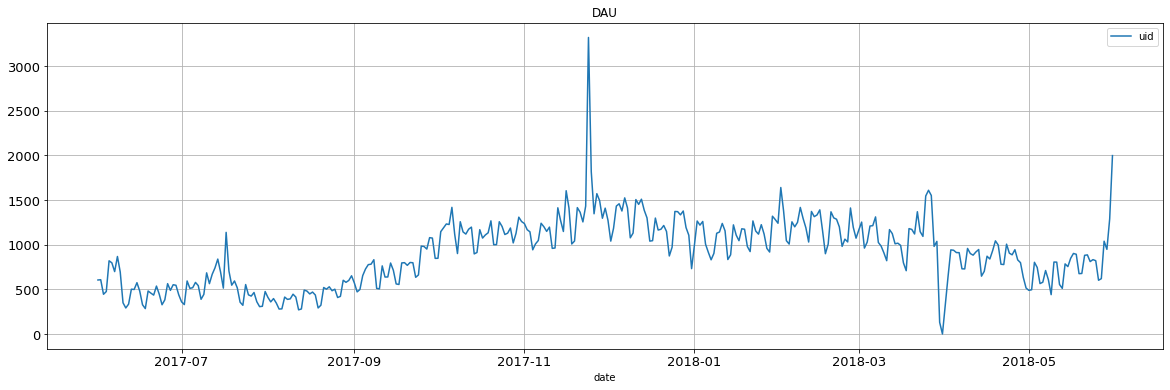

In [126]:
#Построим график
DAU.plot(figsize = (20,6),
         style = '-',
         title = 'DAU',
         fontsize = 13,
         grid = True)

plt.show()

Средний **DAU** за весь период

In [127]:
int(DAU.mean())

907

Показатель среднего **DAU(Daily Active Users)** за весь период **907.**

Посчитаем **WAU(Weekly Active Users)**. Для этого сгруппируем таблицу по дню недели и дате и посчитаем количество уникальных пользователей.

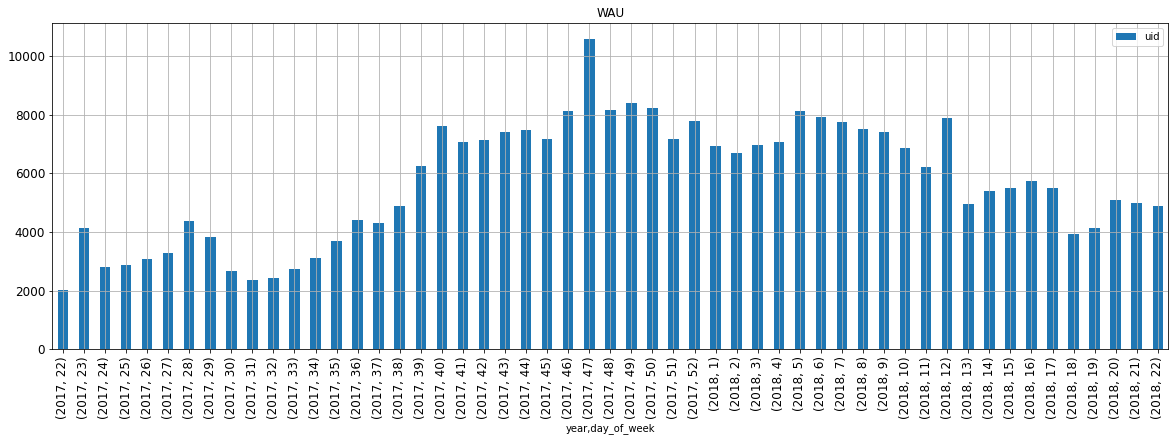

In [128]:
WAU = visits_copy.groupby(['year', 'day_of_week']).agg({'uid': 'nunique'})
WAU.plot(kind = 'bar',
        figsize = (20,6),
         title = 'WAU',
         fontsize = 12,
        grid = True)
plt.show()

Посчитаем средний коэффициент **WAU** за весь период.

In [129]:
int(WAU.mean())

5716

Средний показатель **WAU** за весь период **5716**. 
Рассчитаем еще одну метрику - **MAU(Monthly Active Users)**

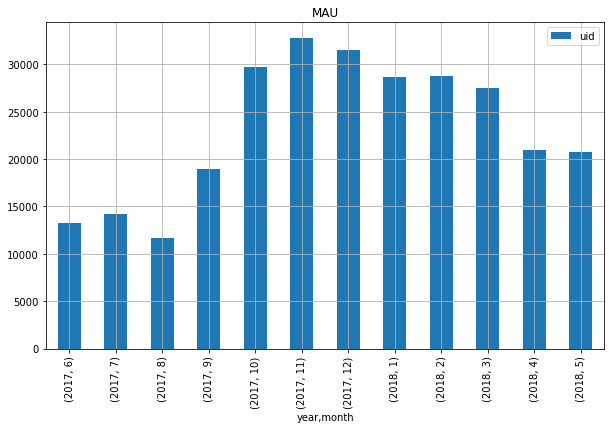

In [130]:
MAU = visits_copy.groupby(['year', 'month']).agg({'uid': 'nunique'})
MAU.plot(kind = 'bar',
        figsize = (10,6),
         title = 'MAU',
        grid = True)
plt.show()

In [131]:
int(MAU.mean())

23228

Показатель **MAU - 23228.** Это уникальные пользователи пришедшие на сайт в месяц. Рассчитаем коэффициент вовлеченности.

In [132]:
sticky_mau = (DAU.mean()/MAU.mean())*100
sticky_mau


uid    3.90897
dtype: float64

In [133]:
sticky_wau = (DAU.mean()/WAU.mean())*100
sticky_wau

uid    15.884409
dtype: float64

Посмотрим сколько пользователей в среднем заходят на сайт.

In [134]:
avg = visits_copy.pivot_table(index = 'date', values = 'uid', aggfunc = 'count')
int(avg.mean())

987

### Вывод  <a id = "open1"></a>
Все три графика показывают **снижение пользовательской активности в летний период**. Возможно, это связано с уменьшением количества мероприятий и периодом отпусков на многих площадках. Но пользователи все равно приходят, возможно смотрят мероприятия на будущее или покупают билеты с запасом времени. 

Коэффициенты  

    DAU: 907, 
    WAU: 5716, 
    MAU: 23228. 
В среднем на сайт заходят 987 пользователей в день. Тогда как коэффициент **DAU 907**. Это говорит о том, что есть те, кто возвращается на сайт не один раз.


[в начало](#start)

##### Рассмотрим время средней сессии. <a id = "mean_ses"></a>

In [135]:
visits_copy['lifetime'] = visits_copy['end_ts'] - visits_copy['start_ts']
visits_copy['lifetime'] = visits_copy['lifetime'].dt.seconds

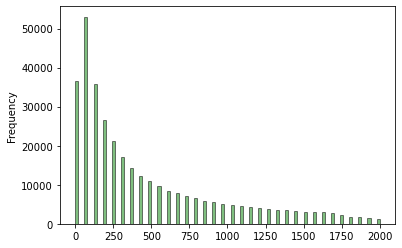

In [136]:
#Построим гистограмму
hist = visits_copy['lifetime'].plot(kind = 'hist',
                                   bins = 100,
                                   range = (0,2000),
                                   alpha=0.5,
                                   ec='black',
                                   color='green'
                                  )
plt.show()

Видно , что это распределение не нормальное. Поэтому посчитать здесь среднее или медиану не имеет смысла. Посчитаем моду.

In [137]:
visits_copy['lifetime'].mode()

0    60
dtype: int64

***Средняя продолжительность сессии 60 секунд.***

[в начало](#start)

Сделаем когортный анализ и посчитаем **коэффициент удержания**. <a id = "RR"></a>

In [138]:
#Выделим для каждого пользователя дату первого входа
first_date = visits_copy.groupby('uid')['start_ts'].min()
first_date.name = 'first_date'
visits_copy = visits_copy.merge(first_date, on = 'uid')

In [139]:
#Выделим из этой даты месяц
visits_copy['first_month'] = visits_copy['first_date'].astype('datetime64[M]')

In [140]:
#Рассчитаем возраст когорт
visits_copy['cohort_lifetime'] = (visits_copy['start_ts']-visits_copy['first_date'])/np.timedelta64(1,'M')
visits_copy['cohort_lifetime'] = visits_copy['cohort_lifetime'].round().astype('int')

In [141]:
visits_copy.head()

,device,end_ts,source_id,start_ts,uid,month,date,day_of_week,year,lifetime,first_date,first_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,12,2017-12-20,51,2017,1080,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2,2018-02-19,8,2018,1680,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,7,2017-07-01,26,2017,0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,5,2018-05-20,20,2018,1440,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,3,2018-03-09,10,2018,1680,2018-03-09 20:05:00,2018-03-01,0


In [142]:
#Сгруппируем данные по первому месяцу и возрасту когорты, посчитаем количесво уникальных пользователей
cohorts = (visits_copy
           .groupby(['first_month', 'cohort_lifetime'])
           .agg({'uid': 'nunique'})
           .reset_index())
#Выделим количество пользователей каждой когорте в начале жизни
cohort_user = cohorts[cohorts['cohort_lifetime']==0][['first_month','uid']]
cohort_user = cohort_user.rename(columns = {'uid': 'cohort_user'})
#склеим таблицы
cohorts = cohorts.merge(cohort_user, on = 'first_month')
#посчитаем отношение количества пользователей к количеству в начале жизни
cohorts['retention'] = (cohorts['uid'] / cohorts['cohort_user'])
#Создадим сводную таблицу
cohorts['first_month'] = cohorts['first_month'].astype('str') 
retention_pivot = (cohorts
                   .pivot_table(index='first_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum'))

retention_pivot.round(2).fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,,
2017-06-01,1.0,0.07,0.05,0.06,0.07,0.07,0.06,0.06,0.06,0.05,0.04,0.04,0.01
2017-07-01,1.0,0.06,0.05,0.05,0.06,0.05,0.04,0.05,0.04,0.03,0.02,0.01,
2017-08-01,1.0,0.07,0.06,0.06,0.05,0.04,0.04,0.03,0.03,0.02,0.0,,
2017-09-01,1.0,0.08,0.07,0.05,0.04,0.04,0.03,0.03,0.02,0.0,,,
2017-10-01,1.0,0.07,0.05,0.04,0.04,0.03,0.02,0.02,0.0,,,,
2017-11-01,1.0,0.07,0.05,0.04,0.03,0.02,0.02,0.0,,,,,
2017-12-01,1.0,0.05,0.04,0.03,0.02,0.02,0.0,,,,,,
2018-01-01,1.0,0.05,0.04,0.03,0.02,0.0,,,,,,,
2018-02-01,1.0,0.05,0.03,0.02,0.0,,,,,,,,


<div class="alert alert-success">

**Комментарий ревьюера**
    
Верный расчет метрики RR, молодец, что визуализировала на тепловой карте. Здорово, что подправила уровень градиентной заливки с помощью параметрам `vmax` Еще в таблицу можно добавить расчет среднего по времени жизни среди всех когорт `retention_pivot.loc['mean'] = retention_pivot.mean()`</div>

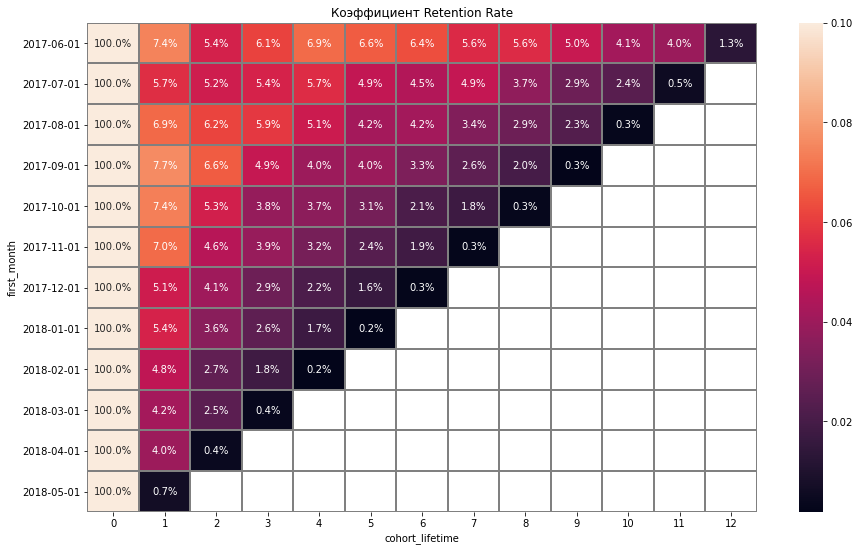

In [143]:
#Построим тепловую карту
plt.figure(figsize=(15, 9))
sns.heatmap(retention_pivot,
            annot=True,
            fmt='.1%',
            linewidths=1,
            linecolor='gray',
            vmax = 0.1)

plt.title('Коэффициент Retention Rate')
plt.show()

На тепловой карте видно , что коэффициент удержания стремительно падает.

Выделим средний коэффициент во второй месяц "жизни" когорт 

In [144]:
round(retention_pivot[1].mean(),2)

0.06

##### Коэффициент удержания всего 6%. Нужно понять почему он такой низкий.

### Вывод: 
По графикам видно, что есть спад спроса в летние месяцы (DAU,WAU,MAU). 
При средней продолжительности сессии в 60 секунд коэффициент удержания очень низкий. На тепловой карте видно, что в 2018 году (в последних когортах) отток пользователей массовый. Судя по всему пользователи приходят, пользуются услугой(или не пользуются,выясним позже) и уходят, не возвращаясь.  Выясним что происходит с покупками.

[в начало](#start)

### Метрики электронной коммерции <a id = "ecom"></a>

In [145]:
#Выделим столбец с временем первого визита.
first_visit = visits_log.groupby('uid')['start_ts'].min().reset_index()
first_visit.columns = ['uid','first_visit']
first_visit.head()

,uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [146]:
#Добавим дату визита и месяц визита
first_visit['first_visit_dt'] = first_visit['first_visit'].dt.date
first_visit['first_visit_month'] = first_visit['first_visit'].astype('datetime64[M]')
first_visit.head()

,uid,first_visit,first_visit_dt,first_visit_month
0,11863502262781,2018-03-01 17:27:00,2018-03-01,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2018-02-06,2018-02-01
2,297729379853735,2017-06-07 18:47:00,2017-06-07,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01
4,325320750514679,2017-09-30 14:29:00,2017-09-30,2017-09-01


In [147]:
#Выделим месяц из даты покупки и добавим новый столбец.
first_orders = orders_log.groupby('uid')['buy_ts'].min().reset_index()
first_orders.columns = ['uid','first_orders_dt']
first_orders['first_orders_month'] = first_orders['first_orders_dt'].astype('datetime64[M]')
first_orders['first_orders_day'] = first_orders['first_orders_dt'].astype('datetime64[D]')

first_orders.head()

,uid,first_orders_dt,first_orders_month,first_orders_day
0,313578113262317,2018-01-03 21:51:00,2018-01-01,2018-01-03
1,1575281904278712,2017-06-03 10:13:00,2017-06-01,2017-06-03
2,2429014661409475,2017-10-11 18:33:00,2017-10-01,2017-10-11
3,2464366381792757,2018-01-28 15:54:00,2018-01-01,2018-01-28
4,2551852515556206,2017-11-24 10:14:00,2017-11-01,2017-11-24


In [148]:
#Склеим таблицы с первыми визитами и первыми покупками по пользователю
byuers = pd.merge(first_visit,first_orders, on = 'uid')
byuers.head()

,uid,first_visit,first_visit_dt,first_visit_month,first_orders_dt,first_orders_month,first_orders_day
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-01,2018-01-03
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-01,2017-06-03
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-01,2017-10-11
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-01,2018-01-28
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-01,2017-11-24


Найдем среднее время, прошедшее от первого визита до покупки.

In [149]:
byuers['time_per_orders'] = ((byuers['first_orders_dt'] - byuers['first_visit'])/np.timedelta64(1,'D')).astype('int')
byuers.head()

,uid,first_visit,first_visit_dt,first_visit_month,first_orders_dt,first_orders_month,first_orders_day,time_per_orders
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-01,2018-01-03,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-01,2017-06-03,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-01,2017-10-11,0
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-01,2018-01-28,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-01,2017-11-24,0


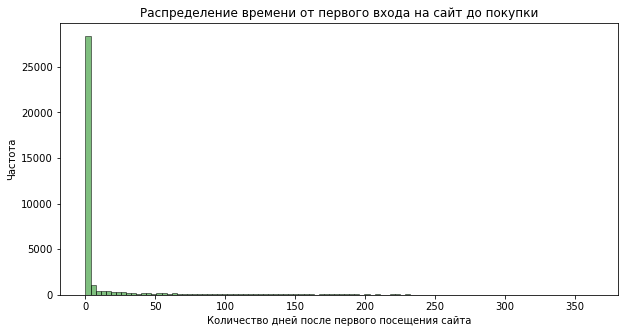

In [150]:
#Пострим гистограмму времени от первого входа на сайт до момента покупки
(byuers['time_per_orders']
 .plot(kind = 'hist',
       bins = 100,
       figsize = (10,5),
       alpha=0.5,
       ec='black',
       color='green')
 .set(title = 'Распределение времени от первого входа на сайт до покупки',
      xlabel = 'Количество дней после первого посещения сайта',
      ylabel = 'Частота'))
plt.show()

Гистограмма показывает не нормальное распределение. Виден пик значений в нуле.

In [151]:
#Найдем среднее время от момента входа до покупки
time_per_orders_mean = byuers['time_per_orders'].mean()
time_per_orders_mean

16.7298688497659

Видно, что среднее не показывает реальную ситуацию. Посчитаем медиану 

In [152]:
time_per_orders_median = byuers['time_per_orders'].median()
time_per_orders_median

0.0

#### Вывод:  
В среднем время от первого визита до покупки 16 дней. Но на гистограмме видно, что, как правило, время сесии близко к нулю. Это значит, что покупка в большинстве случаев происходит сразу при посещении. Это же показывает и медиана. 

[в начало](#start)

Посмотрим сколько покупок совершают посетители в среднем за полгода.

Добавим столбец с датой первой покупки. Поделим на когорты.

In [153]:
orders_log['orders_month'] = orders_log['buy_ts'].astype('datetime64[M]')

In [154]:
# Создадим новый датафрейм, обьединив byuers и orders_log, посчитаем количество покупок
cohort_count = (pd.merge(byuers,orders_log, how = 'inner', on = 'uid')
          .groupby(['first_orders_month','orders_month'])
          .agg({'revenue':'count'})
          .reset_index())
cohort_count.rename(columns = {'revenue':'revenue_count'}, inplace = True)
cohort_count.head()

,first_orders_month,orders_month,revenue_count
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


In [155]:
# Посчитаем количество уникальных пользователей
cohort_size = byuers.groupby('first_orders_month').agg({'uid':'nunique'}).reset_index()
cohort_size.rename(columns = {'uid':'n_buyers'}, inplace = True)
cohort_size

,first_orders_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [156]:
# Рассчитаем возраст когорт
cohort_count['age_cohort'] = (((cohort_count['orders_month']-cohort_count['first_orders_month'])/np.timedelta64(1,'M'))
                              .round().astype('int'))
cohort_count.head()

,first_orders_month,orders_month,revenue_count,age_cohort
0,2017-06-01,2017-06-01,2354,0
1,2017-06-01,2017-07-01,177,1
2,2017-06-01,2017-08-01,174,2
3,2017-06-01,2017-09-01,226,3
4,2017-06-01,2017-10-01,292,4


In [157]:
# Соединим обе таблицы, посчитаем коэффициент
cohort_revenue_count = pd.merge(cohort_size,cohort_count,on = 'first_orders_month')
cohort_revenue_count['amount_buy_per_buyers'] = (cohort_revenue_count['revenue_count']/cohort_revenue_count['n_buyers'])
cohort_revenue_count

,first_orders_month,n_buyers,orders_month,revenue_count,age_cohort,amount_buy_per_buyers
0,2017-06-01,2023,2017-06-01,2354,0,1.163618
1,2017-06-01,2023,2017-07-01,177,1,0.087494
2,2017-06-01,2023,2017-08-01,174,2,0.086011
3,2017-06-01,2023,2017-09-01,226,3,0.111715
4,2017-06-01,2023,2017-10-01,292,4,0.144340
...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,176,2,0.049816
75,2018-04-01,2276,2018-04-01,2495,0,1.096221
76,2018-04-01,2276,2018-05-01,195,1,0.085677
77,2018-05-01,2988,2018-05-01,3249,0,1.087349


In [158]:
# Создадим сводную таблицу для подсчета количества покупок на количество пользователей
#cohort_revenue_count['first_orders_month']= cohort_revenue_count['first_orders_month'].astype('str')
amount_buy_per_buyers = (cohort_revenue_count
                        .pivot_table(index = 'first_orders_month',
                                    columns = 'age_cohort',
                                    values = 'amount_buy_per_buyers',
                                    aggfunc = 'sum')
                        .cumsum(axis=1))
amount_buy_per_buyers.round(2).fillna('')

age_cohort,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07-01,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09-01,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10-01,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02-01,1.12,1.18,1.21,1.22,,,,,,,,


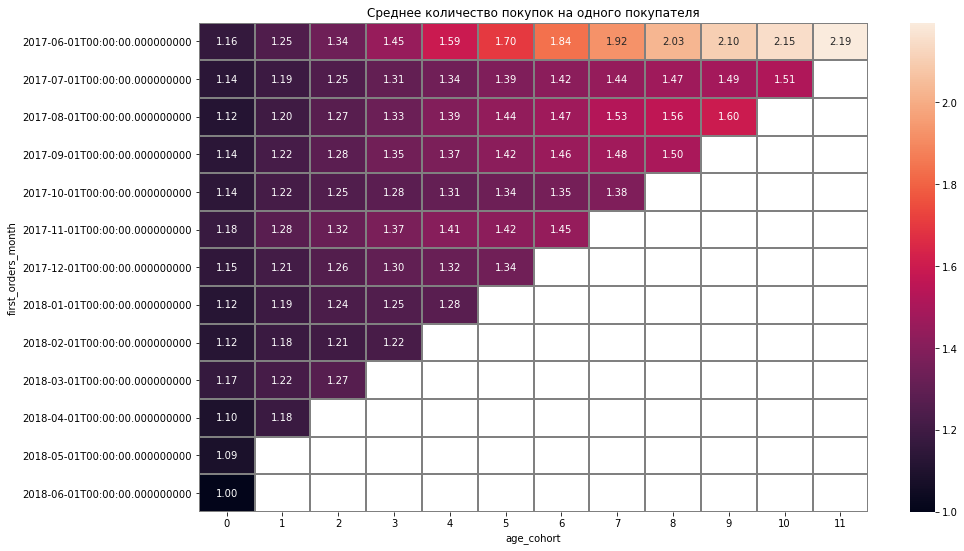

In [159]:
# Построим тепловую карту 
plt.figure(figsize=(15, 9))
plt.title('Cреднее количество покупок на одного покупателя')
sns.heatmap(amount_buy_per_buyers,
            annot=True,
            fmt='.2f',
            linewidths=1,
            linecolor='gray'
           ) 
plt.show()

In [160]:
# Посчитаем среднее количество покупок за полгода
round(amount_buy_per_buyers[5].mean(),2)

1.43

#### Вывод:  
В среднем пользователи совершают 1-2 покупки за полгода. Это отражают результаты предыдущего исследования. Возвращаются пользователи редко.

[в начало](#start)

##### Посчитаем средний чек <a id = "m_chek"></a>

In [161]:
# Суммируем покупки в сгруппированной таблице, почситаем средний чек по когортам
cohort_sum = (pd.merge(orders_log,byuers, how = 'inner', on = 'uid')
          .groupby(['first_orders_month','orders_month'])
          .agg({'revenue':'sum'})
          .reset_index())
cohort_sum.rename(columns = {'revenue':'revenue_sum'}, inplace = True)
cohort_mean_chek = pd.merge(cohort_count,cohort_sum, on = ['first_orders_month','orders_month'])
cohort_mean_chek['sum_per_count'] = cohort_mean_chek['revenue_sum']/cohort_mean_chek['revenue_count']
cohort_mean_chek.head()

,first_orders_month,orders_month,revenue_count,age_cohort,revenue_sum,sum_per_count
0,2017-06-01,2017-06-01,2354,0,9557.49,4.060106
1,2017-06-01,2017-07-01,177,1,981.82,5.547006
2,2017-06-01,2017-08-01,174,2,885.34,5.088161
3,2017-06-01,2017-09-01,226,3,1931.30,8.545575
4,2017-06-01,2017-10-01,292,4,2068.58,7.084178


In [162]:
#Построим сводную таблицу
cohort_mean_chek['first_orders_month'] = cohort_mean_chek['first_orders_month'].astype('str')
mean_chek =(cohort_mean_chek
            .pivot_table(index='first_orders_month',
                        columns = 'age_cohort',
                        values = 'sum_per_count',
                        aggfunc = 'sum'))
            
mean_chek.round(2).fillna('')

age_cohort,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04
2017-07-01,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,
2017-08-01,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.7,5.6,,
2017-09-01,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,,,
2017-10-01,4.37,7.41,5.13,5.59,5.1,5.07,4.28,4.01,,,,
2017-11-01,4.37,4.1,4.47,6.28,4.44,3.73,4.6,,,,,
2017-12-01,4.11,4.23,20.07,26.08,15.95,14.11,,,,,,
2018-01-01,3.69,4.44,6.45,7.52,2.71,,,,,,,
2018-02-01,3.71,4.58,3.45,3.87,,,,,,,,


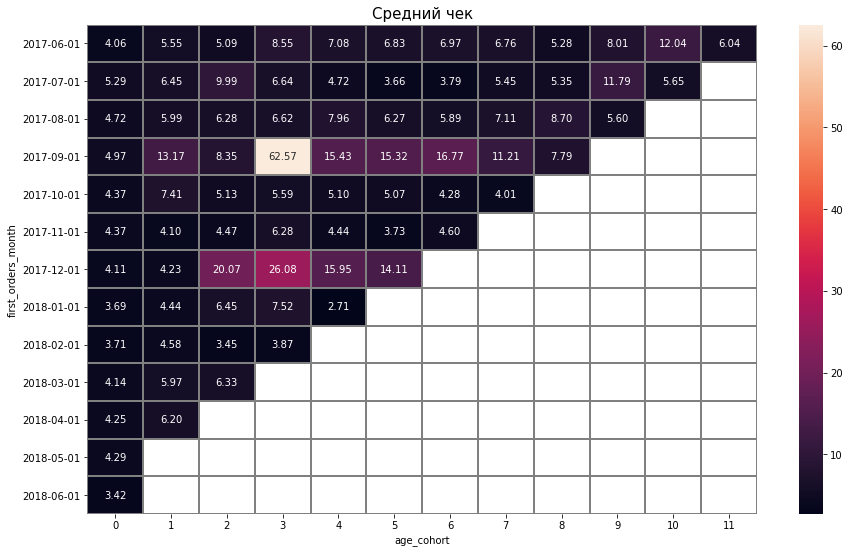

In [163]:
plt.figure(figsize=(15, 9))
plt.title('Cредний чек',fontsize = 15)
sns.heatmap(mean_chek,
            annot=True,
            fmt='.2f',
            linewidths=1,
            linecolor='gray'
           ) 
plt.show()

Явно отличаются сентябрьская и декабрьская когорты. В сентябрьской средний чек в декабре достиг пика. Во всех остальных когортах средний чек невысокий. Опять же, когорты 2018 года с низким показателем( максимум в январской когорте 7,5 у.е.).


[в начало](#start)

##### Посчитаем коэффициент LTV <a id = "LTV"></a>

In [164]:
byuers.head()

,uid,first_visit,first_visit_dt,first_visit_month,first_orders_dt,first_orders_month,first_orders_day,time_per_orders
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-01,2018-01-03,106
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-01,2017-06-03,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-01,2017-10-11,0
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-01,2018-01-28,0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-01,2017-11-24,0


In [165]:
#Посчитаем количество уникальных пользователей по месяцу первой покупки
cohort_size = byuers.groupby('first_orders_month').agg({'uid':'nunique'}).reset_index()
cohort_size.rename(columns = {'uid':'n_buyers'}, inplace = True)
cohort_size

,first_orders_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [166]:
#Создадим таблицу для подсчета из созданных ранее.
cohort_ltv = pd.merge(cohort_sum,cohort_size,on = 'first_orders_month')
cohort_ltv

,first_orders_month,orders_month,revenue_sum,n_buyers
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023
...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533
75,2018-04-01,2018-04-01,10600.69,2276
76,2018-04-01,2018-05-01,1209.92,2276
77,2018-05-01,2018-05-01,13925.76,2988


In [167]:
#Создадим столбец  с отношением суммарной выручки к количеству уникальных пользователей
cohort_ltv['rev_per_buyers'] = cohort_ltv['revenue_sum']/cohort_ltv['n_buyers']

In [168]:
#Добавим столбец с возрастом когорты
cohort_ltv['age_cohort'] = ((cohort_ltv['orders_month']-cohort_ltv['first_orders_month'])/np.timedelta64(1,'M')).round().astype('int')
cohort_ltv.head()

,first_orders_month,orders_month,revenue_sum,n_buyers,rev_per_buyers,age_cohort
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2017-07-01,981.82,2023,0.485329,1
2,2017-06-01,2017-08-01,885.34,2023,0.437637,2
3,2017-06-01,2017-09-01,1931.30,2023,0.954671,3
4,2017-06-01,2017-10-01,2068.58,2023,1.022531,4


In [169]:
#Создадим сводную таблицу и посчитаем LTV
cohort_ltv['first_orders_month'] = cohort_ltv['first_orders_month'].astype('str')
LTV = (cohort_ltv
       .pivot_table(index = 'first_orders_month',
                    columns = 'age_cohort',
                    values = 'rev_per_buyers',
                    aggfunc = 'sum')
       .cumsum(axis=1))

LTV.round(2).fillna('')                       

age_cohort,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5.0,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


<div class="alert alert-success">

**Комментарий ревьюера**
    
Отличные и верные расчеты среднего чека, количествопокупок на пользователя и LTV 👍 Молодец, что все визуализировала на тепловых картах. Хорошо, что сделала накопительный расчет LTV, в выводе можно еще написать про ухудшеие или улучшение LTV за 1 месяц для новых когорт. Так же можно доабвить расчет среднего по времени жизни среди всех когорт. Смотри пример к RR</div>

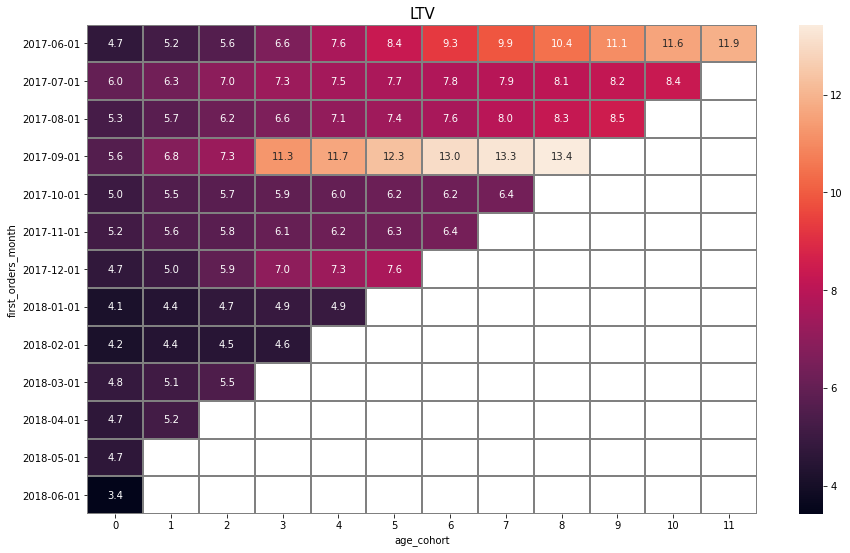

In [170]:
plt.figure(figsize=(15, 9))
plt.title('LTV',fontsize = 15)
sns.heatmap(LTV,
            annot=True,
            fmt='.1f',
            linewidths=1,
            linecolor='gray'            
           ) 
plt.show()

In [171]:
#Посчитаем средний LTV за полгода
round(LTV[5].mean(),2)

7.97

#### Вывод: 

За полгода в среднем делают почти 8 покупок, т.е. 1-2 покупки в месяц. На тепловой карте хорошо видны когорты,в которых покупки совершаются регулярно. Это июньская и сентябрьская когорты.
Пиковое значение среднего чека в декабре у сентябрьской когорты очень интересно. Возможно, люди покупали подарки, или была запущена акция макретологами. У остальных когорт показатели низкие и не превышают средних. 
Опять отличаются когорты начала 2018 года, LTV не превышает 5,5 у.е.


[в начало](#start)

#### Маркетинговые метрики <a id = "mm"></a>

In [172]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [173]:
#Добавим столбец с месяцем
costs['month'] = costs['dt'].astype('datetime64[M]')

In [174]:
#Создадим сводную таблицу для подсчета маркетинговых затрат по источникам
cost_per_sours = (costs
                  .pivot_table(index = 'month',
                             columns = 'source_id',
                             values = 'costs',
                             aggfunc='sum'))
cost_per_sours.index = cost_per_sours.index.astype('str')
cost_per_sours

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


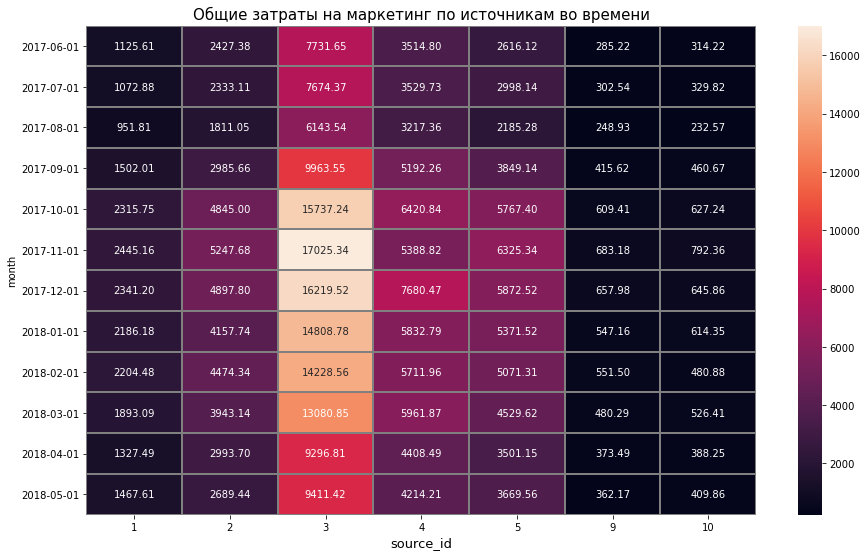

In [175]:
plt.figure(figsize=(15, 9))
plt.title('Общие затраты на маркетинг по источникам во времени', fontsize = 15)
plt.xlabel('Источники', fontsize = 13)
sns.heatmap(cost_per_sours,
            annot=True,
            fmt='.2f',
            linewidths=1,
            linecolor='gray'
           ) 
plt.show()

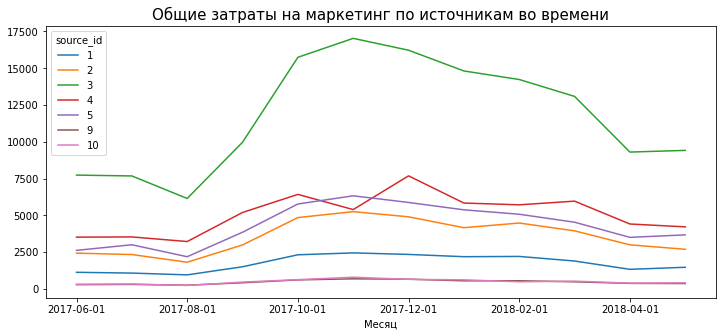

In [176]:
#Построим график затрат на маркетинг по источникам
cost_per_sours.plot(figsize = (12,5))
                   
plt.title('Общие затраты на маркетинг по источникам во времени',fontsize = 15)
plt.xlabel('Месяц')
plt.show()

Из графика видно, что наибольшие траты были на третий источник. Начиная с сентября по апрель они превышали 10 000 у.е. В то время как траты на 9й и 10й источник очень маленькие. 


[в начало](#start)

##### Посчитаем CAC по всем источникам. <a id = "mm1"></a>

In [177]:
visits_log.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [178]:
#Выделим для каждого пользователя источник первого входа
users = visits_log.sort_values('start_ts').groupby('uid').first()
users = users[['source_id']]
users

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5
...,...
18446403737806311543,5
18446424184725333426,4
18446556406699109058,3


In [179]:
#Склеим таблицы по uid
byuers = pd.merge(byuers,users, on = 'uid')
byuers.head()

,uid,first_visit,first_visit_dt,first_visit_month,first_orders_dt,first_orders_month,first_orders_day,time_per_orders,source_id
0,313578113262317,2017-09-18 22:49:00,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-01,2018-01-03,106,2
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-01,2017-06-03,0,10
2,2429014661409475,2017-10-11 17:14:00,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-01,2017-10-11,0,3
3,2464366381792757,2018-01-27 20:10:00,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-01,2018-01-28,0,5
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-01,2017-11-24,0,5


In [180]:
#Сгруппируем данные по источнику и дате первой покупки, посчитаем количесво пользователей на каддый день
byuers_daily = (byuers
                .groupby(['source_id','first_orders_day'])
                .agg({'uid':'count'})
               .reset_index())
byuers_daily.rename(columns = {'uid':'n_byuers'}, inplace = True)
byuers_daily               

,source_id,first_orders_day,n_byuers
0,1,2017-06-01,14
1,1,2017-06-02,7
2,1,2017-06-03,7
3,1,2017-06-04,3
4,1,2017-06-05,18
...,...,...,...
2430,10,2018-05-27,2
2431,10,2018-05-28,10
2432,10,2018-05-29,7
2433,10,2018-05-30,5


In [181]:
#Склеим таблицы с покупателями и затратами на маркетинг по источнику и дате
coast_per_byuers = pd.merge(byuers_daily,costs,left_on = ['source_id','first_orders_day'], right_on = ['source_id','dt'])
coast_per_byuers.head()

,source_id,first_orders_day,n_byuers,dt,costs,month
0,1,2017-06-01,14,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,7,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,7,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,3,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,18,2017-06-05,57.08,2017-06-01


In [182]:
# Добавим столбец с коэффициентом САС 
coast_per_byuers['coast_per_byuers'] = coast_per_byuers['costs']/coast_per_byuers['n_byuers']
coast_per_byuers.head()

,source_id,first_orders_day,n_byuers,dt,costs,month,coast_per_byuers
0,1,2017-06-01,14,2017-06-01,75.20,2017-06-01,5.371429
1,1,2017-06-02,7,2017-06-02,62.25,2017-06-01,8.892857
2,1,2017-06-03,7,2017-06-03,36.53,2017-06-01,5.218571
3,1,2017-06-04,3,2017-06-04,55.00,2017-06-01,18.333333
4,1,2017-06-05,18,2017-06-05,57.08,2017-06-01,3.171111


In [183]:
#Построим сводную таблицу по месяцам
CAC = (coast_per_byuers
       .pivot_table(index = 'month',
                   columns = 'source_id',
                   values = 'coast_per_byuers',
                   aggfunc = 'mean'))
CAC

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,11.681283,12.883568,16.716919,10.792094,9.209676,5.253654,4.590158
2017-07-01,9.491485,18.000253,18.593952,8.054482,7.938157,5.582433,6.151880
2017-08-01,12.118898,18.886449,19.795068,11.554926,6.879620,4.900254,5.813398
2017-09-01,8.155731,17.672249,13.084043,9.533800,6.864844,6.049126,8.306581
2017-10-01,8.202083,14.193003,14.613088,6.233562,6.305969,5.923235,6.362921
2017-11-01,8.908503,17.437690,16.091445,5.013132,9.368019,9.400503,10.801337
2017-12-01,8.570439,13.871086,12.948321,5.656507,8.399174,7.899420,7.803197
2018-01-01,11.719181,15.850151,15.134989,5.901092,9.371755,9.792713,9.851557
2018-02-01,10.752216,18.209325,13.894612,5.428068,7.725369,8.181382,4.489624


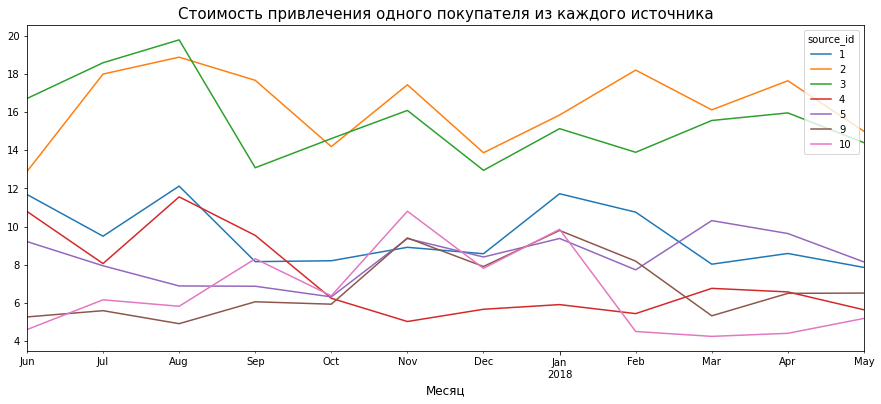

In [184]:
#Построим график затрат на пользователя по источникам
CAC.plot(figsize = (15,6))
plt.title('Стоимость привлечения одного покупателя из каждого источника',fontsize = 15)
plt.xlabel('Месяц',fontsize = 12)
plt.show()

#### Вывод:

Из графика видно, что стоимость привлечения пользователей высока у второго источника. Возможно, это означает, что при высоких тратах с этого источника пришло мало пользователей.
При этом стоимость привлечения по 4му источнику сильно упала. Возможно, здесь обратная ситуация, при прежних вложениях приходит больше пользователей.

[в начало](#start)

In [185]:
#Посчитаем среднее САС по источникам
CAC_mean = coast_per_byuers.groupby('source_id')[['coast_per_byuers']].mean()
CAC_mean

,coast_per_byuers
source_id,
1,9.489732
2,16.287024
3,15.580474
4,7.271743
5,8.336731
9,6.842532
10,6.555415


In [186]:
#Создадим датафрейм для подсчета LTV по источникам
df = pd.merge(orders_log,byuers, how = 'inner', on = 'uid')
df.head()

,buy_ts,revenue,uid,orders_month,first_visit,first_visit_dt,first_visit_month,first_orders_dt,first_orders_month,first_orders_day,time_per_orders,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,2017-06-01,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,2017-06-01,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:14:00,2017-06-01,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:31:00,2017-06-01,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3


#####  Посчитаем ROMI <a id = "romi"></a>

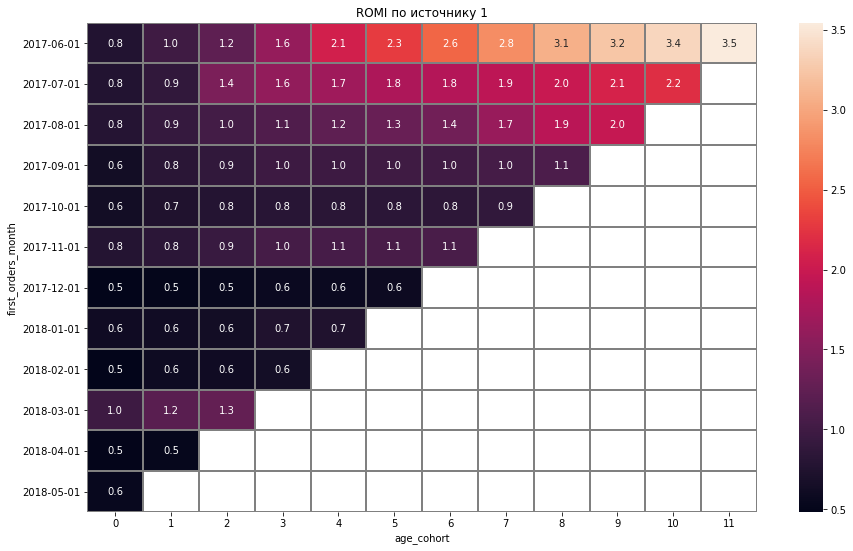

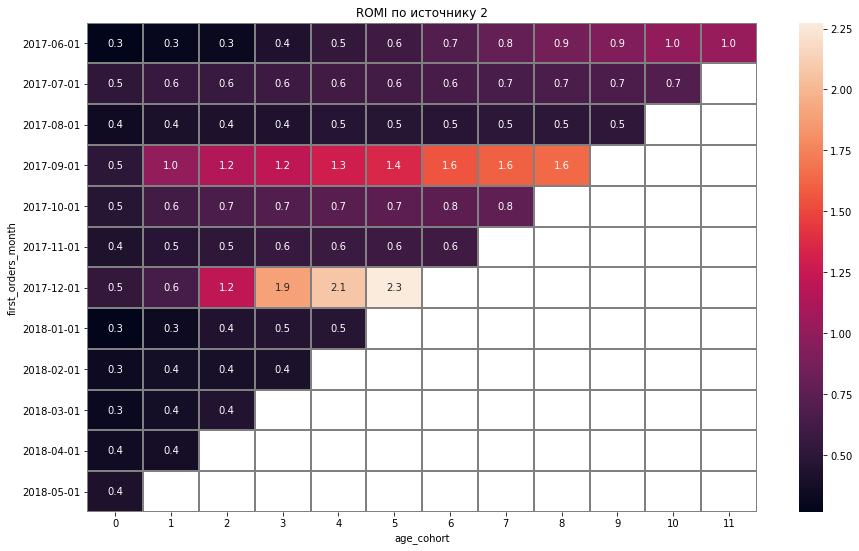

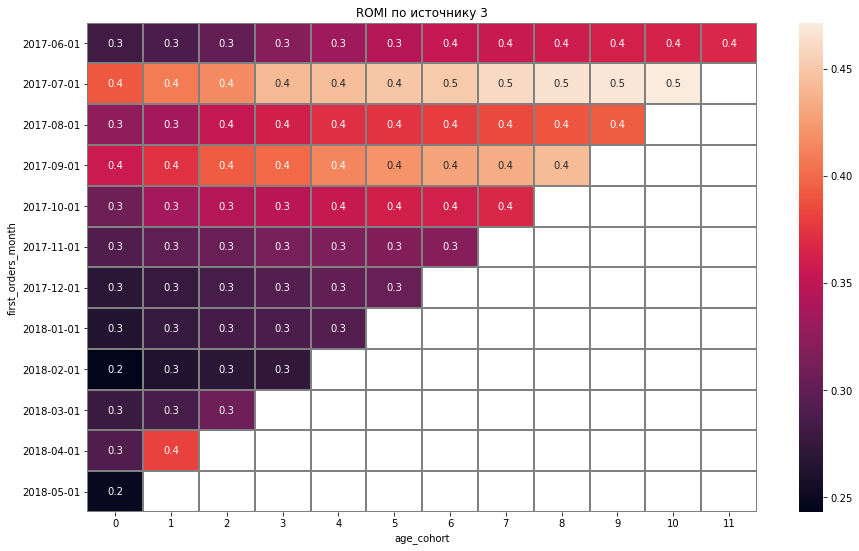

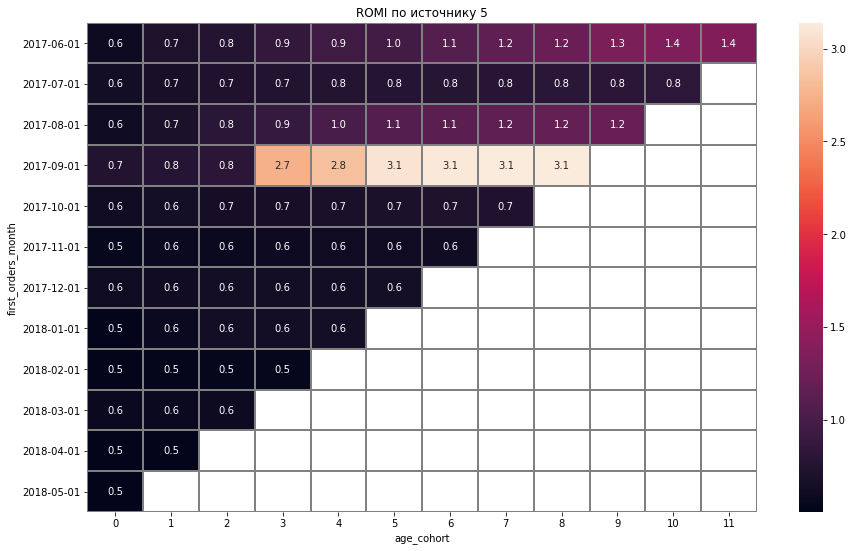

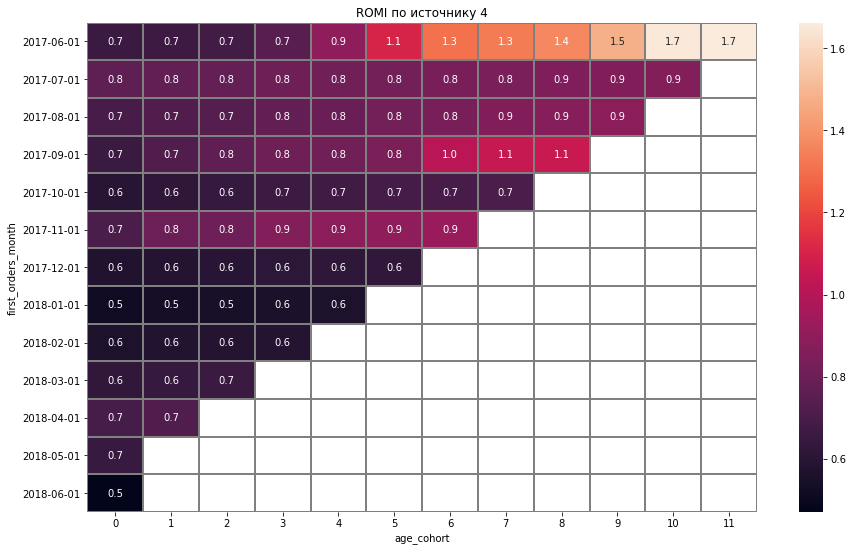

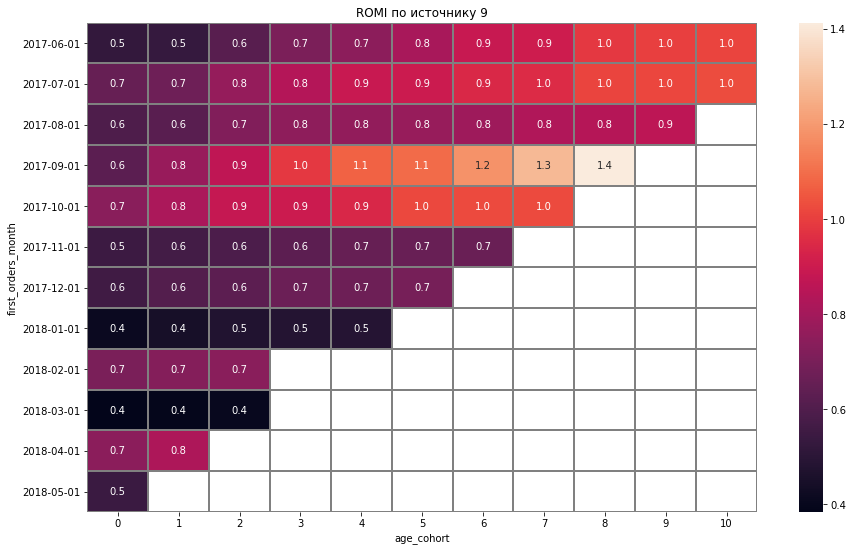

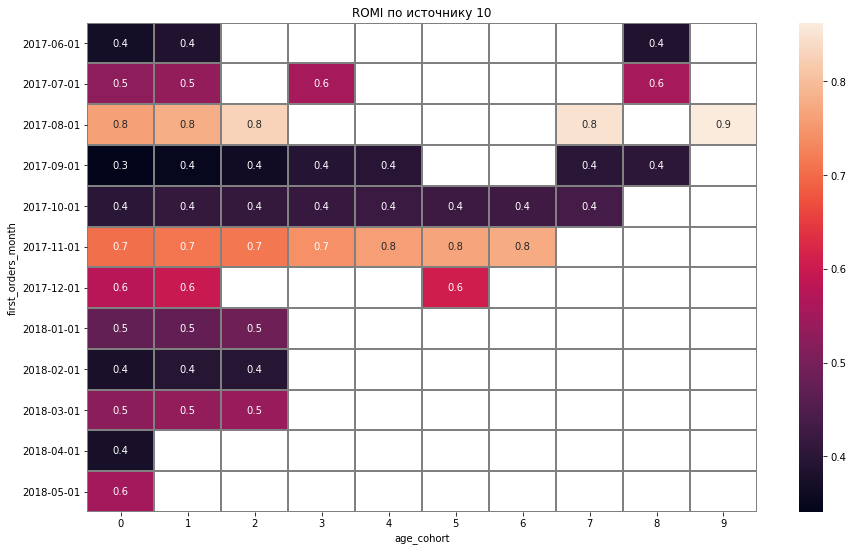

In [188]:
#Создадим цикл, который посчитает LTV по источникам, разделим это значение на САС по источнику и построим тепловые карты

for value in df['source_id'].unique():
    try: # не в каждом источнике достаточно данных для построения когорты
        df_i = df[df['source_id'] == value]
        cohort_df = (df_i
              .groupby(['first_orders_month','orders_month'])
              .agg({'revenue':'sum'})
              .reset_index())
        cohort_df.rename(columns = {'revenue':'revenue_sum'}, inplace = True)
        cohort_age = df_i.groupby('first_orders_month').agg({'uid':'nunique'}).reset_index()
        cohort_age.rename(columns = {'uid':'n_buyers'}, inplace = True)

        cohort_ltv = pd.merge(cohort_df,cohort_age,on = 'first_orders_month')
        cohort_ltv

        cohort_ltv['rev_per_buyers'] = cohort_ltv['revenue_sum']/cohort_ltv['n_buyers']

        cohort_ltv['age_cohort'] = (((cohort_ltv['orders_month']-cohort_ltv['first_orders_month'])/np.timedelta64(1,'M'))
                                    .round().astype('int'))
        cohort_ltv['ROMI'] = cohort_ltv['rev_per_buyers']/CAC_mean['coast_per_byuers'][value]
        cohort_ltv['first_orders_month'] = cohort_ltv['first_orders_month'].astype('str')
        ROMI = (cohort_ltv
           .pivot_table(index = 'first_orders_month',
                        columns = 'age_cohort',
                        values = 'ROMI',
                        aggfunc = 'sum')
           .cumsum(axis=1)
          )

        ROMI.round(2).fillna('') 
        plt.figure(figsize=(15, 9))
        plt.title('ROMI по источнику {}'.format(value))
        sns.heatmap(ROMI,
                annot=True,
                fmt='.1f',
                linewidths=1,
                linecolor='gray') 
        plt.show()

    except KeyError:
        pass

    



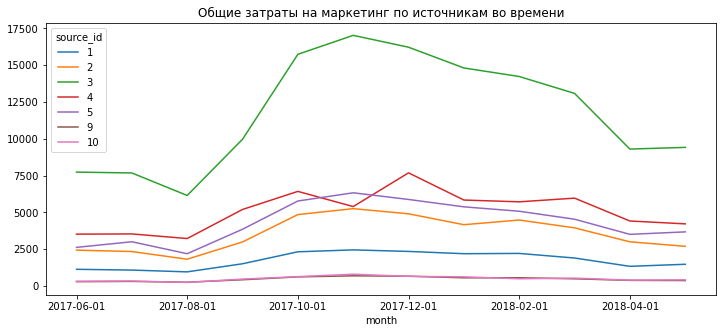

In [189]:
cost_per_sours.plot(figsize = (12,5),
                   title = 'Общие затраты на маркетинг по источникам во времени')
plt.show()

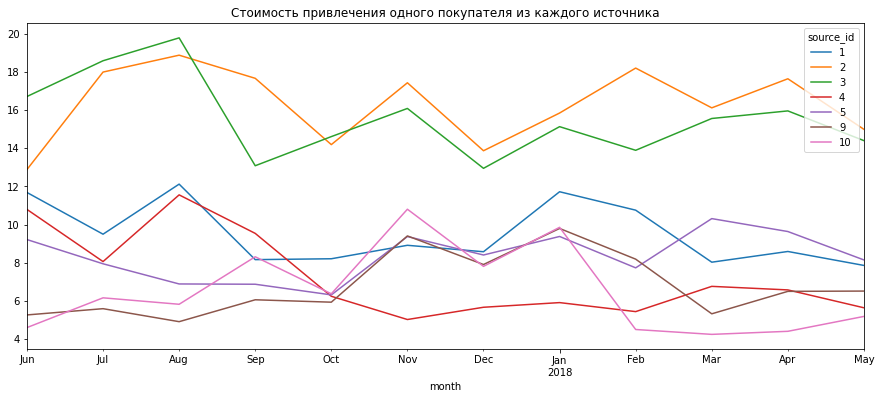

In [190]:
CAC.plot(figsize = (15,6),
        title = 'Стоимость привлечения одного покупателя из каждого источника')
plt.show()

[в начало](#start)

### Вывод: <a id = "open"></a>

**Источник 1** 

По окупаемости первый источник показывает хорошие результаты в 2017 году. Окупаемость буквально со второго или третьего месяца. В мартовской когорте окупаемость буквально в первый месяц. Возможно , была реклама или акция, запущенная маркетингом.


**Источник 2**  

По окупаемости второй источник показал другие результаты:
окупились только две когорты сентябрьская и декабрьская.Январская окупилась за год. При этом из графика маркетинговых затрат видно, что стоимость пользователя здесь высока.  

**Источник 3** 

Из графиков видно, что затраты на третий источник самые высокие, при это стоимость привлечения пользователя тоже очень высока. При этом не окупилась ни одна когорта. Я считаю, что этот источник не стоит таких вложений, лучше переключить эти средства на источник, который окупается. 

**Источник 4** 

Затраты на четвертый источник меньше, чем на третий, но чуть больше, чем на все остальные источники.Окупились всего 2 когорты:июньская и сентябрьская. И при этом в 2018 году хорошие коэффициенты на окупаемость в будущем. Период окупаемости здесь больше чем, в первой или второй(6-7 месяцев). Но в этот источник имеет смысл вложиться.

**Источник 5** 

Окупаемость в 5м источнике тоже присутствует в трех когортах: августовская и,опять июньская и сентябрьская. При этом при одинаковых затратах на продвижение в 2017 году когорты окупились, а в 2018 показатель даже не меняется со временем. Я бы обратила внимание на то, какие акции проводились маркетингом в период с июня по сентябрь 2017. Потому что именно они принесли клиентов, которые покупают.

**Источник 9** 

При невысоких затратах на привлечение по этому источнику видна окупаемость в первые полгода. Прибыль превышает затраты буквально через 4-6 месяцев стабильно. Опять же, коэффициенты не растут в 2018 году. Возможно , имеет смысл вложить средства на продвижение сюда.

**Источник 10** 

По источнику 10 видимо мало данных. Тепловая карта показывает, что ни одна когорта не окупилась. Но коэффициенты близки к 1. Возможно, если бы было больше данных и при должных финансовых вливаниях,то картина была бы другой. Сейчас финансирование этого источника минимальное. 

### Итог: 
Как показало исследование, есть источники, которые не приносят дохода. Мало того, они хорошо финансируются. По каждому источнику я написала рекомендации и возможные пути развития. Предполагаю, что достаточное финансирование перспективных источников привлечет больше покупателей и повысит и средний чек, коэфиициент возврата.

[в начало](#start)